<a href="https://colab.research.google.com/github/OksanaBut77/TFM/blob/main/TFM_farmacias_Clustering_mode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
sns.set(style="whitegrid")

In [36]:
df_member = pd.read_csv('/content/drive/MyDrive/TFM/df_member_base.csv')
print(df_member.head(5))

   depart_id  card_id  member_class    last_consume_time  card_type  \
0     270297  1936560          3407                  NaN          0   
1     270297  3208730          1515  2020-01-22 09:18:15          0   
2     270155  4053650          1700  2021-11-13 09:57:18          0   
3     270155  4053950          1672  2021-12-05 18:49:25          0   
4     270297  4133810          3407                  NaN          0   

   define_class  is_suff  level    birthday  consume_level  point  \
0           170        0      2  1968-12-01              1    0.0   
1           426        0      2  1954-07-24              1    0.0   
2           578        0      3  2016-09-02              1    0.0   
3           287        0      3  1951-09-13              1    0.0   
4           170        0      2  2015-12-28              1    0.0   

            updatetime  sex   age  Recency  
0  2021-09-13 06:18:05  0.0  53.0      NaN  
1  2021-09-13 06:18:05  0.0  67.0    599.0  
2  2021-11-28 05:31:55 

In [37]:
print(df_member.shape)

(10000, 15)


In [38]:
print("\nValores nulos por columna:")
print(df_member.isnull().sum())


Valores nulos por columna:
depart_id               0
card_id                 0
member_class            0
last_consume_time    5786
card_type               0
define_class            0
is_suff                 0
level                   0
birthday                6
consume_level           0
point                   0
updatetime              0
sex                  3249
age                     6
Recency              5786
dtype: int64


In [39]:
# Recorremos cada columna y rellenamos los nulos con la moda
for col in df_member.columns:
    moda = df_member[col].mode()
    if not moda.empty:  # comprobamos que exista una moda
        df_member[col] = df_member[col].fillna(moda[0])

In [40]:
print(df_member.isnull().sum())

depart_id            0
card_id              0
member_class         0
last_consume_time    0
card_type            0
define_class         0
is_suff              0
level                0
birthday             0
consume_level        0
point                0
updatetime           0
sex                  0
age                  0
Recency              0
dtype: int64


In [42]:
df_member_clean=df_member.copy()

In [43]:
df_member_clean.shape

(10000, 15)

# Migración de clientes entre clusters (2016-2021)

In [44]:
# Análisis de migración de clientes entre clusters (2016-2021)

# Configuración para visualización
plt.style.use('default')
sns.set_style("whitegrid")

In [45]:
# last_consume_time a datetime
df_member_clean['last_consume_time'] = pd.to_datetime(df_member_clean['last_consume_time'])

# año para segmentar los períodos
df_member_clean['year'] = df_member_clean['last_consume_time'].dt.year

In [46]:
df_member_clean.columns

Index(['depart_id', 'card_id', 'member_class', 'last_consume_time',
       'card_type', 'define_class', 'is_suff', 'level', 'birthday',
       'consume_level', 'point', 'updatetime', 'sex', 'age', 'Recency',
       'year'],
      dtype='object')

In [47]:
# Preprocesamiento de datos
def preprocess_data(data):
    # columnas relevantes para el clustering
    features = ['member_class', 'card_type', 'define_class', 'is_suff',
                'level', 'consume_level', 'point', 'sex', 'age', 'Recency']

    # Filtramos el dataset y manejamos valores nulos
    df_clean = data[features].copy()
    # Escalamos los datos
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_clean)

    return df_scaled, features

In [48]:
# Función clustering KMeans
def perform_clustering(data_scaled, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(data_scaled)
    return clusters, kmeans

In [49]:
# Dividir el dataset en los períodos
df_2016_2017 = df_member_clean[df_member_clean['year'].isin([2016, 2017])].copy()
df_2017_2018 = df_member_clean[df_member_clean['year'].isin([2017, 2018])].copy()
df_2018_2019 = df_member_clean[df_member_clean['year'].isin([2018, 2019])].copy()
df_2019_2020 = df_member_clean[df_member_clean['year'].isin([2019, 2020])].copy()
df_2020_2021 = df_member_clean[df_member_clean['year'].isin([2020, 2021])].copy()

# Imprimir la cantidad de clientes en cada período
print("\nNúmero de registros por período:")
print(f"2016-2017: {len(df_2016_2017)}")
print(f"2017-2018: {len(df_2017_2018)}")
print(f"2018-2019: {len(df_2018_2019)}")
print(f"2019-2020: {len(df_2019_2020)}")
print(f"2020-2021: {len(df_2020_2021)}")


Número de registros por período:
2016-2017: 7011
2017-2018: 588
2018-2019: 578
2019-2020: 674
2020-2021: 2411


In [50]:
# Identificar clientes únicos en cada período
unique_2016_2017 = set(df_2016_2017['card_id'].unique())
unique_2017_2018 = set(df_2017_2018['card_id'].unique())
unique_2018_2019 = set(df_2018_2019['card_id'].unique())
unique_2019_2020 = set(df_2019_2020['card_id'].unique())
unique_2020_2021 = set(df_2020_2021['card_id'].unique())

print(f"\nClientes únicos por período:")
print(f"2016-2017: {len(unique_2016_2017)}")
print(f"2017-2018: {len(unique_2017_2018)}")
print(f"2018-2019: {len(unique_2018_2019)}")
print(f"2019-2020: {len(unique_2019_2020)}")
print(f"2020-2021: {len(unique_2020_2021)}")


Clientes únicos por período:
2016-2017: 7011
2017-2018: 588
2018-2019: 578
2019-2020: 674
2020-2021: 2411


In [51]:
# Identificar clientes que aparecen en múltiples períodos
common_clients_2016_2017_to_2017_2018 = unique_2016_2017.intersection(unique_2017_2018)
common_clients_2017_2018_to_2018_2019 = unique_2017_2018.intersection(unique_2018_2019)
common_clients_2018_2019_to_2019_2020 = unique_2018_2019.intersection(unique_2019_2020)
common_clients_2019_2020_to_2020_2021 = unique_2019_2020.intersection(unique_2020_2021)

print(f"\nClientes presentes en múltiples períodos:")
print(f"Presentes en 2016-2017 y 2017-2018: {len(common_clients_2016_2017_to_2017_2018)}")
print(f"Presentes en 2017-2018 y 2018-2019: {len(common_clients_2017_2018_to_2018_2019)}")
print(f"Presentes en 2018-2019 y 2019-2020: {len(common_clients_2018_2019_to_2019_2020)}")
print(f"Presentes en 2019-2020 y 2020-2021: {len(common_clients_2019_2020_to_2020_2021)}")


Clientes presentes en múltiples períodos:
Presentes en 2016-2017 y 2017-2018: 322
Presentes en 2017-2018 y 2018-2019: 266
Presentes en 2018-2019 y 2019-2020: 312
Presentes en 2019-2020 y 2020-2021: 362



ANÁLISIS PARA EL PERÍODO 2016-2017
Registros únicos por cliente: 7011

Distribución de clusters para 2016-2017:
cluster
0    3315
1    1319
2    2377
Name: count, dtype: int64


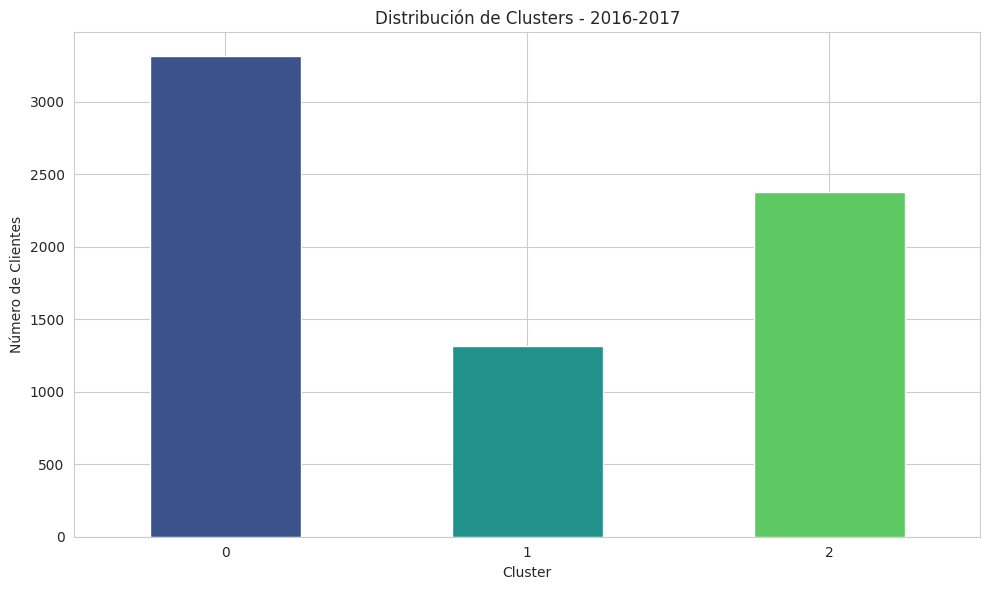


ANÁLISIS PARA EL PERÍODO 2017-2018
Registros únicos por cliente: 588

Distribución de clusters para 2017-2018:
cluster
0    286
1    270
2     32
Name: count, dtype: int64


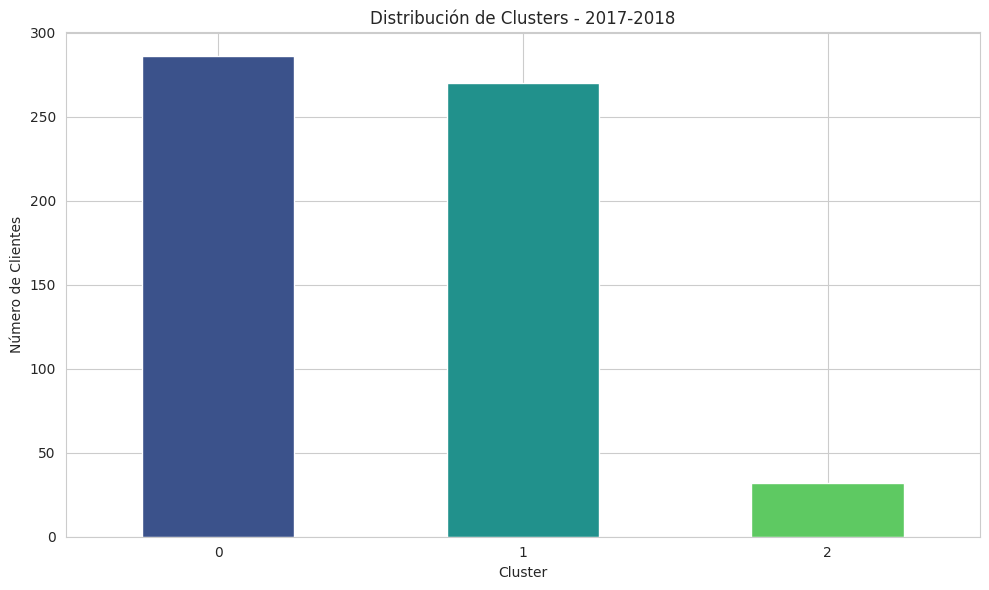


ANÁLISIS PARA EL PERÍODO 2018-2019
Registros únicos por cliente: 578

Distribución de clusters para 2018-2019:
cluster
0    541
1     36
2      1
Name: count, dtype: int64


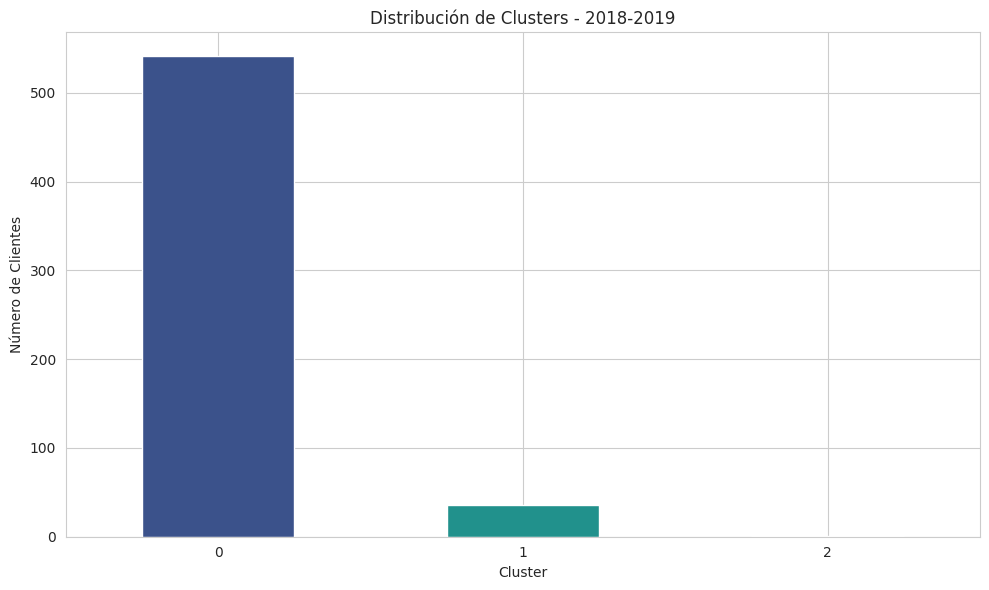


ANÁLISIS PARA EL PERÍODO 2019-2020
Registros únicos por cliente: 674

Distribución de clusters para 2019-2020:
cluster
0    339
1    309
2     26
Name: count, dtype: int64


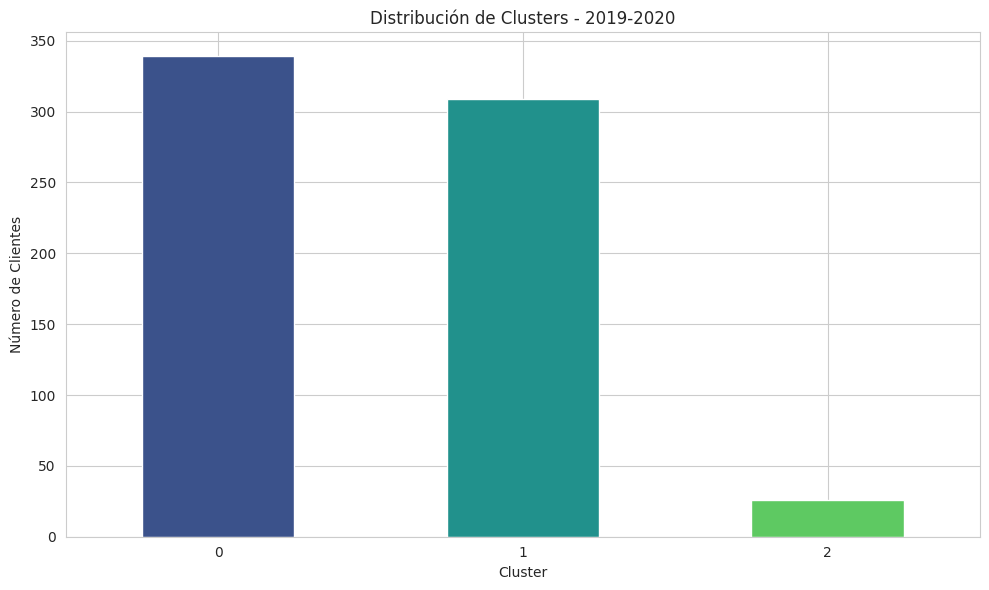


ANÁLISIS PARA EL PERÍODO 2020-2021
Registros únicos por cliente: 2411

Distribución de clusters para 2020-2021:
cluster
0    978
1    753
2    680
Name: count, dtype: int64


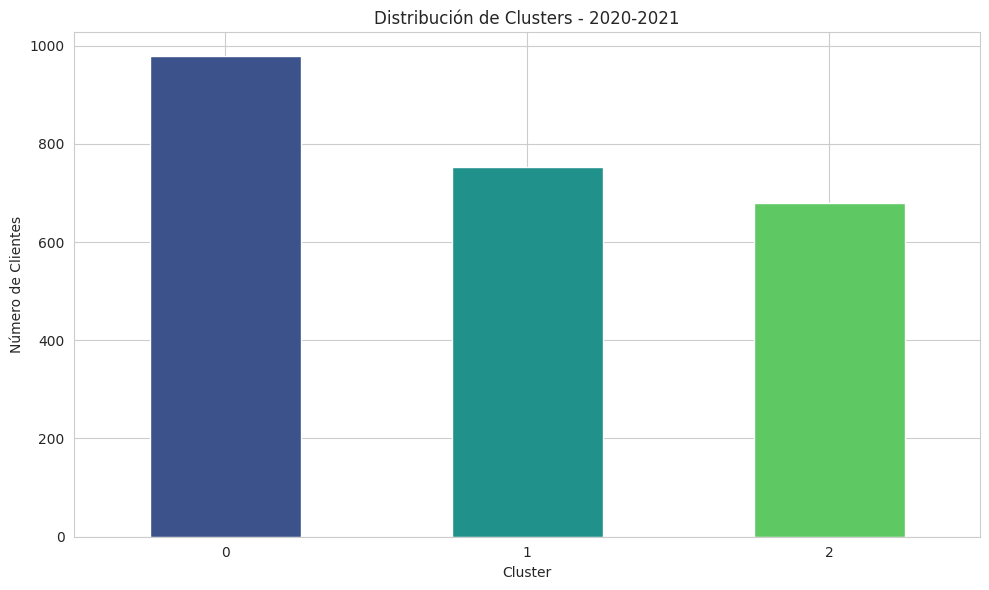

In [52]:
# clustering para cada período
def analyze_period(df_period, period_name):
    print(f"\n{'='*50}")
    print(f"ANÁLISIS PARA EL PERÍODO {period_name}")
    print(f"{'='*50}")

    if len(df_period) == 0:
        print(f"No hay datos para el período {period_name}")
        return df_period

    # Para evitar duplicados por cliente, tomamos el registro más reciente por cliente
    df_period_unique = df_period.sort_values('last_consume_time').groupby('card_id').tail(1).copy()
    print(f"Registros únicos por cliente: {len(df_period_unique)}")

    # Preprocesamiento
    try:
        data_scaled, features = preprocess_data(df_period_unique)

        # Clustering
        clusters, kmeans_model = perform_clustering(data_scaled)
        df_period_unique['cluster'] = clusters

        # Análisis de los clusters
        print(f"\nDistribución de clusters para {period_name}:")
        cluster_counts = df_period_unique['cluster'].value_counts().sort_index()
        print(cluster_counts)

        # distribución de los clusters
        plt.figure(figsize=(10, 6))
        cluster_counts.plot(kind='bar', color=sns.color_palette('viridis', len(cluster_counts)))
        plt.title(f'Distribución de Clusters - {period_name}')
        plt.xlabel('Cluster')
        plt.ylabel('Número de Clientes')
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()

        return df_period_unique

    except Exception as e:
        print(f"Error en el análisis del período {period_name}: {str(e)}")
        return df_period

# Analizar cada período
df_2016_2017_analyzed = analyze_period(df_2016_2017, '2016-2017')
df_2017_2018_analyzed = analyze_period(df_2017_2018, '2017-2018')
df_2018_2019_analyzed = analyze_period(df_2018_2019, '2018-2019')
df_2019_2020_analyzed = analyze_period(df_2019_2020, '2019-2020')
df_2020_2021_analyzed = analyze_period(df_2020_2021, '2020-2021')


In [53]:
# DataFrame: ID & cluster
dfs = {
    '2016-2017': df_2016_2017_analyzed[['card_id', 'cluster']].rename(columns={'cluster': 'cluster_16_17'}),
    '2017-2018': df_2017_2018_analyzed[['card_id', 'cluster']].rename(columns={'cluster': 'cluster_17_18'}),
    '2018-2019': df_2018_2019_analyzed[['card_id', 'cluster']].rename(columns={'cluster': 'cluster_18_19'}),
    '2019-2020': df_2019_2020_analyzed[['card_id', 'cluster']].rename(columns={'cluster': 'cluster_19_20'}),
    '2020-2021': df_2020_2021_analyzed[['card_id', 'cluster']].rename(columns={'cluster': 'cluster_20_21'}),
}

# merge progresivo de todos los años
from functools import reduce
df_all = reduce(lambda left, right: pd.merge(left, right, on='card_id', how='outer'), dfs.values())

In [59]:
output_path = '/content/drive/MyDrive/TFM/df_all_clusters_2016_2021_mode.csv'
df_all.to_csv(output_path, index=False)

#from google.colab import files
#files.download(output_path)

In [55]:
import plotly.graph_objects as go

# conexiones entre cada par de años
links = []
labels = []
label_map = {}

def get_label_index(label):
    if label not in label_map:
        label_map[label] = len(label_map)
        labels.append(label)
    return label_map[label]

# flujos entre años consecutivos
years = ['16_17', '17_18', '18_19', '19_20', '20_21']
for i in range(len(years) - 1):
    col_source = f'cluster_{years[i]}'
    col_target = f'cluster_{years[i+1]}'

    temp = df_all[[col_source, col_target]].dropna()
    flows = temp.groupby([col_source, col_target]).size().reset_index(name='count')

    for _, row in flows.iterrows():
        source_label = f"{years[i]}_C{int(row[col_source])}"
        target_label = f"{years[i+1]}_C{int(row[col_target])}"

        source = get_label_index(source_label)
        target = get_label_index(target_label)

        links.append(dict(source=source, target=target, value=row['count']))

In [56]:
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color="blue"
    ),
    link=dict(
        source=[link['source'] for link in links],
        target=[link['target'] for link in links],
        value=[link['value'] for link in links]
    ))])

fig.update_layout(
    title=dict(
        text="Client migration between clusters (2016–2021)",
        x=0.5,
        xanchor='center'
    ),
    font_size=10
)

fig.show()

In [57]:
import plotly.graph_objects as go

# conexiones entre cada par de años
links = []
labels = []
label_map = {}

def get_label_index(label):
    if label not in label_map:
        label_map[label] = len(label_map)
        labels.append(label)
    return label_map[label]

# flujos entre años consecutivos
years = ['19_20', '20_21']
for i in range(len(years) - 1):
    col_source = f'cluster_{years[i]}'
    col_target = f'cluster_{years[i+1]}'

    temp = df_all[[col_source, col_target]].dropna()
    flows = temp.groupby([col_source, col_target]).size().reset_index(name='count')

    for _, row in flows.iterrows():
        source_label = f"{years[i]}_C{int(row[col_source])}"
        target_label = f"{years[i+1]}_C{int(row[col_target])}"

        source = get_label_index(source_label)
        target = get_label_index(target_label)

        links.append(dict(source=source, target=target, value=row['count']))

In [58]:
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color="blue"
    ),
    link=dict(
        source=[link['source'] for link in links],
        target=[link['target'] for link in links],
        value=[link['value'] for link in links]
    ))])

fig.update_layout(
    title=dict(
        text="Client migration between clusters (2020–2021)",
        x=0.5,
        xanchor='center'
    ),
    font_size=10
)

fig.show()

-------------------